In [25]:
import urllib.request
import zipfile
import os

# Download the dataset
url = 'https://phm-datasets.s3.amazonaws.com/NASA/6.+Turbofan+Engine+Degradation+Simulation+Data+Set.zip'
file_name = 'Turbofan_Engine_Degradation_Simulation_Data.zip'

urllib.request.urlretrieve(url, file_name)

# Extract the dataset
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall('Turbofan_Engine_Degradation_Simulation_Data')


In [30]:
import urllib.request
import zipfile
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Download the dataset
url = 'https://phm-datasets.s3.amazonaws.com/NASA/6.+Turbofan+Engine+Degradation+Simulation+Data+Set.zip'
file_name = 'Turbofan_Engine_Degradation_Simulation_Data.zip'

urllib.request.urlretrieve(url, file_name)

# Extract the outer zip file
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall('Turbofan_Engine_Degradation_Simulation_Data')

# Path to the inner zip file
inner_zip_path = 'Turbofan_Engine_Degradation_Simulation_Data/6. Turbofan Engine Degradation Simulation Data Set/CMAPSSData.zip'

# Extract the inner zip file
with zipfile.ZipFile(inner_zip_path, 'r') as zip_ref:
    zip_ref.extractall('Turbofan_Engine_Degradation_Simulation_Data/CMAPSSData')

# List the directory structure
for root, dirs, files in os.walk('Turbofan_Engine_Degradation_Simulation_Data/CMAPSSData'):
    level = root.replace('Turbofan_Engine_Degradation_Simulation_Data/CMAPSSData', '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print(f'{subindent}{f}')

# Adjust the file path based on the directory structure
train_data_path = 'Turbofan_Engine_Degradation_Simulation_Data/CMAPSSData/train_FD001.txt'

# Load the dataset
def load_data(file_path):
    data = pd.read_csv(file_path, sep=' ', header=None)
    data.dropna(axis=1, how='all', inplace=True)
    data.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i}' for i in range(1, 22)]
    return data

# Load data
data = load_data(train_data_path)
print(data.head())

# Generate labels: remaining useful life (RUL)
def add_rul(data):
    data['RUL'] = data.groupby('id')['cycle'].transform(max) - data['cycle']
    return data

data = add_rul(data)

# Features and labels
features = data.drop(columns=['id', 'cycle', 'RUL'])
labels = data['RUL']

# Standardize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential([
    LSTM(100, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Print the model summary
model.summary()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    np.expand_dims(X_train, axis=2), y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss = model.evaluate(np.expand_dims(X_test, axis=2), y_test)
print(f'Test Loss: {test_loss}')

# Make predictions
y_pred = model.predict(np.expand_dims(X_test, axis=2))

# Convert predictions and true values to a DataFrame
results = pd.DataFrame({'True': y_test, 'Predicted': y_pred.flatten()})
print(results.head())

# Save the model
model.save('predictive_maintenance_model.h5')


CMAPSSData/
    Damage Propagation Modeling.pdf
    readme.txt
    RUL_FD001.txt
    RUL_FD002.txt
    RUL_FD003.txt
    RUL_FD004.txt
    test_FD001.txt
    test_FD002.txt
    test_FD003.txt
    test_FD004.txt
    train_FD001.txt
    train_FD002.txt
    train_FD003.txt
    train_FD004.txt
   id  cycle  setting1  setting2  setting3  sensor1  sensor2  sensor3  \
0   1      1   -0.0007   -0.0004     100.0   518.67   641.82  1589.70   
1   1      2    0.0019   -0.0003     100.0   518.67   642.15  1591.82   
2   1      3   -0.0043    0.0003     100.0   518.67   642.35  1587.99   
3   1      4    0.0007    0.0000     100.0   518.67   642.35  1582.79   
4   1      5   -0.0019   -0.0002     100.0   518.67   642.37  1582.85   

   sensor4  sensor5  ...  sensor12  sensor13  sensor14  sensor15  sensor16  \
0  1400.60    14.62  ...    521.66   2388.02   8138.62    8.4195      0.03   
1  1403.14    14.62  ...    522.28   2388.07   8131.49    8.4318      0.03   
2  1404.20    14.62  ...    522.42  

C:\Users\yadav\AppData\Local\Temp\ipykernel_9828\1227211150.py:55: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  data['RUL'] = data.groupby('id')['cycle'].transform(max) - data['cycle']
C:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,901 (179.30 KB)

 Trainable params: 45,901 (179.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 15331.9619 - val_loss: 2825.0103
Epoch 2/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 2936.2334 - val_loss: 2174.2847
Epoch 3/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 2516.0520 - val_loss: 2127.6011
Epoch 4/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 2485.9727 - val_loss: 2049.0898
Epoch 5/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 2355.2766 - val_loss: 2025.8347
Epoch 6/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 2368.9900 - val_loss: 2076.5049
Epoch 7/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 2316.5776 - val_loss: 2016.3314
Epoch 8/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 2245.8728 - val_loss: 2040.5277
Epoch 9/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 2209.5337 - val_loss: 1964.0319
Epoch 10/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 2136.5720 - val_loss: 1981.0071
Epoch 11/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - l

       True   Predicted
13857   135  136.385666
1710      2    7.720906
9278    217  180.664108
10786     0    3.071830
19709   178  129.325485


In [31]:
# Build the LSTM model
model = Sequential([
    LSTM(100, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Print the model summary
model.summary()


C:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,901 (179.30 KB)

 Trainable params: 45,901 (179.30 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    np.expand_dims(X_train, axis=2), y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping]
)


Epoch 1/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 16827.1992 - val_loss: 15712.9346
Epoch 2/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 13803.2061 - val_loss: 2090.6035
Epoch 3/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 2631.6560 - val_loss: 2185.3984
Epoch 4/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 2418.6680 - val_loss: 1975.8049
Epoch 5/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 2406.1599 - val_loss: 1988.3419
Epoch 6/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 2368.7678 - val_loss: 2029.2677
Epoch 7/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 2254.5684 - val_loss: 1987.8534
Epoch 8/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 2300.4692 - val_loss: 2056.7024
Epoch 9/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 2250.7090 - val_loss: 2088.8809
Epoch 10/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 2235.6045 - val_loss: 2082.3594
Epoch 11/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step -

In [33]:
# Evaluate the model on the test set
test_loss = model.evaluate(np.expand_dims(X_test, axis=2), y_test)
print(f'Test Loss: {test_loss}')

# Make predictions
y_pred = model.predict(np.expand_dims(X_test, axis=2))

# Convert predictions and true values to a DataFrame
results = pd.DataFrame({'True': y_test, 'Predicted': y_pred.flatten()})
print(results.head())


129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1643.9368
Test Loss: 1706.0743408203125
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
       True   Predicted
13857   135  130.379990
1710      2    8.954698
9278    217  177.740814
10786     0    2.770295
19709   178  118.467644


In [37]:
# Save the model in the native Keras format
model.save('predictive_maintenance_model.keras')


In [38]:
from tensorflow.keras.models import load_model

# Load the model in the native Keras format
model = load_model('predictive_maintenance_model.keras')


C:\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 9 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [40]:
# Take a sample from the existing data for demonstration
new_data = features.iloc[0:1, :]  # Taking the first sample


In [41]:
# Preprocess new_data
new_data_scaled = scaler.transform(new_data)
new_data_predictions = model.predict(np.expand_dims(new_data_scaled, axis=2))

print(new_data_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
[[162.95287]]


In [42]:
import urllib.request
import zipfile
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Download the dataset
url = 'https://phm-datasets.s3.amazonaws.com/NASA/6.+Turbofan+Engine+Degradation+Simulation+Data+Set.zip'
file_name = 'Turbofan_Engine_Degradation_Simulation_Data.zip'

urllib.request.urlretrieve(url, file_name)

# Extract the outer zip file
with zipfile.ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall('Turbofan_Engine_Degradation_Simulation_Data')

# Path to the inner zip file
inner_zip_path = 'Turbofan_Engine_Degradation_Simulation_Data/6. Turbofan Engine Degradation Simulation Data Set/CMAPSSData.zip'

# Extract the inner zip file
with zipfile.ZipFile(inner_zip_path, 'r') as zip_ref:
    zip_ref.extractall('Turbofan_Engine_Degradation_Simulation_Data/CMAPSSData')

# List the directory structure
for root, dirs, files in os.walk('Turbofan_Engine_Degradation_Simulation_Data/CMAPSSData'):
    level = root.replace('Turbofan_Engine_Degradation_Simulation_Data/CMAPSSData', '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print(f'{subindent}{f}')

# Adjust the file path based on the directory structure
train_data_path = 'Turbofan_Engine_Degradation_Simulation_Data/CMAPSSData/train_FD001.txt'

# Load the dataset
def load_data(file_path):
    data = pd.read_csv(file_path, sep=' ', header=None)
    data.dropna(axis=1, how='all', inplace=True)
    data.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3'] + [f'sensor{i}' for i in range(1, 22)]
    return data

# Load data
data = load_data(train_data_path)
print(data.head())

# Generate labels: remaining useful life (RUL)
def add_rul(data):
    data['RUL'] = data.groupby('id')['cycle'].transform(max) - data['cycle']
    return data

data = add_rul(data)

# Features and labels
features = data.drop(columns=['id', 'cycle', 'RUL'])
labels = data['RUL']

# Standardize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential([
    LSTM(100, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Print the model summary
model.summary()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    np.expand_dims(X_train, axis=2), y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=[early_stopping]
)

# Evaluate the model on the test set
test_loss = model.evaluate(np.expand_dims(X_test, axis=2), y_test)
print(f'Test Loss: {test_loss}')

# Make predictions
y_pred = model.predict(np.expand_dims(X_test, axis=2))

# Convert predictions and true values to a DataFrame
results = pd.DataFrame({'True': y_test, 'Predicted': y_pred.flatten()})
print(results.head())

# Save the model in the native Keras format
model.save('predictive_maintenance_model.keras')

# Load the model in the native Keras format
model = load_model('predictive_maintenance_model.keras')

# Define new_data
new_data = features.iloc[0:1, :]  # Taking the first sample for demonstration

# Preprocess new_data
new_data_scaled = scaler.transform(new_data)
new_data_predictions = model.predict(np.expand_dims(new_data_scaled, axis=2))

print(new_data_predictions)


CMAPSSData/
    Damage Propagation Modeling.pdf
    readme.txt
    RUL_FD001.txt
    RUL_FD002.txt
    RUL_FD003.txt
    RUL_FD004.txt
    test_FD001.txt
    test_FD002.txt
    test_FD003.txt
    test_FD004.txt
    train_FD001.txt
    train_FD002.txt
    train_FD003.txt
    train_FD004.txt
   id  cycle  setting1  setting2  setting3  sensor1  sensor2  sensor3  \
0   1      1   -0.0007   -0.0004     100.0   518.67   641.82  1589.70   
1   1      2    0.0019   -0.0003     100.0   518.67   642.15  1591.82   
2   1      3   -0.0043    0.0003     100.0   518.67   642.35  1587.99   
3   1      4    0.0007    0.0000     100.0   518.67   642.35  1582.79   
4   1      5   -0.0019   -0.0002     100.0   518.67   642.37  1582.85   

   sensor4  sensor5  ...  sensor12  sensor13  sensor14  sensor15  sensor16  \
0  1400.60    14.62  ...    521.66   2388.02   8138.62    8.4195      0.03   
1  1403.14    14.62  ...    522.28   2388.07   8131.49    8.4318      0.03   
2  1404.20    14.62  ...    522.42  

C:\Users\yadav\AppData\Local\Temp\ipykernel_9828\1052326684.py:55: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  data['RUL'] = data.groupby('id')['cycle'].transform(max) - data['cycle']
C:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,901 (179.30 KB)

 Trainable params: 45,901 (179.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 11933.1758 - val_loss: 2486.1960
Epoch 2/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 2696.5488 - val_loss: 2106.7363
Epoch 3/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 2529.1790 - val_loss: 2026.5397
Epoch 4/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 2334.0911 - val_loss: 2074.0715
Epoch 5/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 2413.5015 - val_loss: 2025.8702
Epoch 6/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 2307.5249 - val_loss: 1963.2566
Epoch 7/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 2304.3582 - val_loss: 2024.1224
Epoch 8/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 2274.3762 - val_loss: 1997.2239
Epoch 9/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 2190.1541 - val_loss: 1974.8263
Epoch 10/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 2180.3882 - val_loss: 2011.7930
Epoch 11/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - l

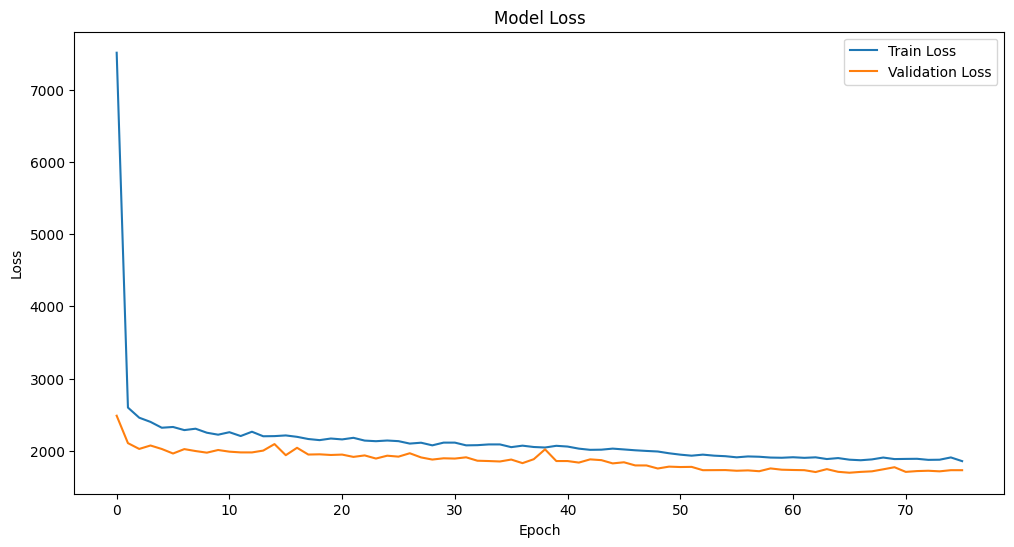

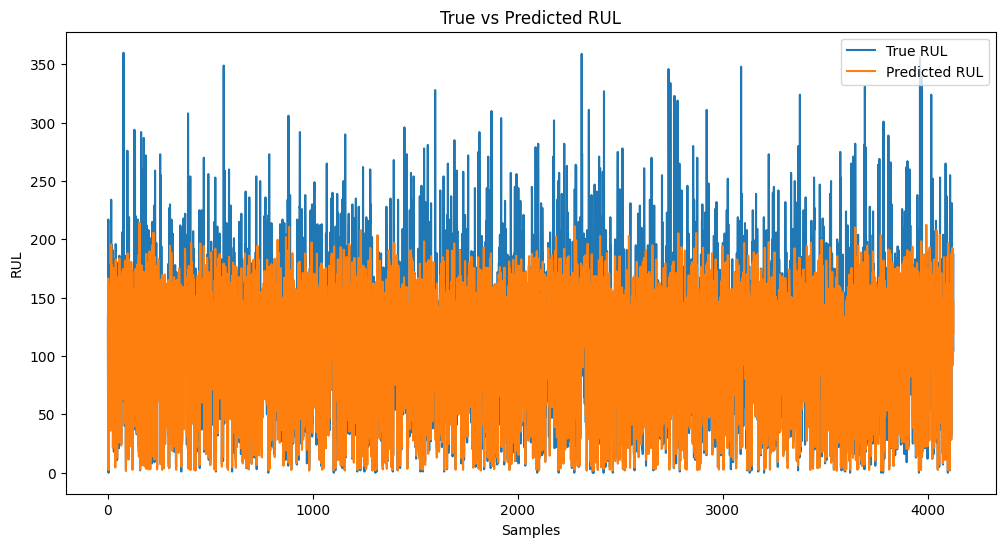

In [43]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot true vs predicted RUL
plt.figure(figsize=(12, 6))
plt.plot(results['True'].values, label='True RUL')
plt.plot(results['Predicted'].values, label='Predicted RUL')
plt.title('True vs Predicted RUL')
plt.ylabel('RUL')
plt.xlabel('Samples')
plt.legend(loc='upper right')
plt.show()


In [44]:
from flask import Flask, request, jsonify
from tensorflow.keras.models import load_model
import numpy as np

# Load the model
model = load_model('predictive_maintenance_model.h5')

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json(force=True)
    data_scaled = scaler.transform(np.array(data['features']).reshape(1, -1))
    prediction = model.predict(np.expand_dims(data_scaled, axis=2))
    return jsonify({'RUL': prediction[0][0]})

if __name__ == '__main__':
    app.run(port=5000, debug=True)


ModuleNotFoundError: No module named 'flask'